In [ ]:
import glob
import itertools
import logging
import os
import pickle
import time
import torch
import torchvision
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from google.colab import drive
from skimage import feature,exposure
from skimage.color import convert_colorspace,rgb2gray
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces
!unzip 140k-real-and-fake-faces

In [ ]:
data_path = os.getcwd()+'/real_vs_fake/real-vs-fake/'
data = {'img_path':[],'label':[],'purpose':[]}

for where in os.listdir(data_path):
  for status in os.listdir(data_path+'/'+where):
    for img in glob.glob(data_path+where+'/'+status+'/'+'*.jpg'):
      data['img_path'].append(img)
      data['label'].append(status)
      data['purpose'].append(where)

data = pd.DataFrame(data)
train = data[data.purpose=='train'].reset_index(drop=True)
test = data[data.purpose=='test'].reset_index(drop=True)

In [ ]:
# Training set label counts
train['label'].value_counts()

fake    50000
real    50000
Name: label, dtype: int64

In [ ]:
# Testing set label counts
test['label'].value_counts()

fake    10000
real    10000
Name: label, dtype: int64

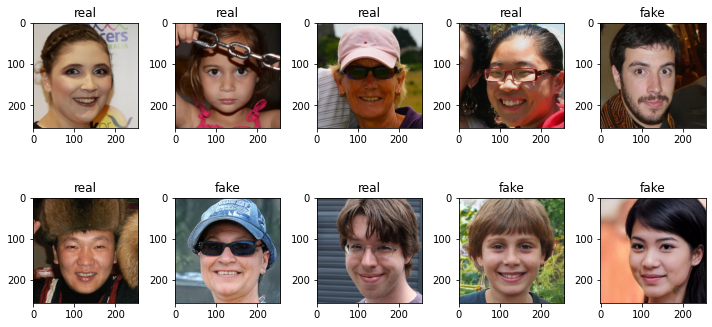

In [ ]:
# Sample data
plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(2,5,i+1)
  random = np.random.randint(1,len(data))
  plt.imshow(plt.imread(data.loc[random,'img_path']))
  plt.title(data.loc[random,'label'])
plt.tight_layout()
plt.show()

### Code Base

In [ ]:
# Miscellaneous functions
class Utils:
  def __init__(self,random_seed):
    self.random_seed = random_seed
  
  def stratified_sampling(self,data,sample_size):
    """
    Generated random subset of data with balanced label counts
    """

    self.data = data
    self.sample_size = sample_size

    np.random.seed(self.random_seed)
    data_size = self.data.shape[0]
    indices = np.random.randint(low=0,high=data_size+1,size=sample_size)
    data_subset = self.data.iloc[indices,:]
    return data_subset

  def apply_sampling(self,train,test,train_sample_size,test_sample_size):
    """
    Apply stratified sampling to training and testing set and obtain desired number of data points
    """

    self.train = train
    self.test = test
    self.train_sample_size = train_sample_size
    self.test_sample_size = test_sample_size

    # With sampled training and testing set, in that order
    output = []

    for i,dt in enumerate([self.train,self.test]):
      dt_size = self.train_sample_size if i==0 else self.test_sample_size

      # Sample from real labeled data
      dt_real = dt[dt.label=='real']
      dt_real_subset = self.stratified_sampling(dt_real,int(dt_size/2))

      # Sample from fake labeled data
      dt_fake = dt[dt.label=='fake']
      dt_fake_subset = self.stratified_sampling(dt_fake,int(dt_size/2))

      dt_sample = pd.concat([dt_real_subset,dt_fake_subset],axis=0).reset_index(drop=True)

      output.append(dt_sample)
    
    return output
  
  def process_img(self,data,resize_,gamma_correction_,ycbcr_,grayscale_,edge_detection_):
    """
    Convert the img_path in the data file to pixel arrays and extract the labels, subjected to various 
    preprocessing steps

      Parameters:
        data (dataframe): pandas dataframe with img path
        resize_ (bool,float): tuple containing whether it is implemented and the desired output dimension
        gamma_correction_ (bool,float): tuple containing whether it is implemented and the gamma parameter value
        ycbcr_ (bool): whether to apply the above gamma correction to ycbcr or rgb image
        grayscale_ (bool): boolean value of whether grayscale is implemented
        edge_detection_ (bool,float): tuple containing whether it is implemented and the sigma parameter value
    """

    self.data = data
    self.resize_ = resize_
    self.gamma_correction_ = gamma_correction_
    self.ycbcr_ = ycbcr_
    self.grayscale_ = grayscale_
    self.edge_detection_ = edge_detection_
    

    imgs_flat = []
    labels = []

    n = self.data.shape[0]

    for i in range(n):
      img_array = np.array(imread(self.data.loc[i,'img_path']))

      if self.resize_[0]==True:
        output_dim = self.resize_[1]
        img_array = resize(img_array,(output_dim,output_dim,3))

      if self.gamma_correction_[0]==True:
        gamma_val = self.gamma_correction_[1]
        if self.ycbcr_==True:
          img_array = convert_colorspace(img_array,'RGB','YCbCr')
          img_array = exposure.adjust_gamma(img_array,gamma_val)
          img_array = convert_colorspace(img_array,'YCbCr','RGB')
        else:
          img_array = exposure.adjust_gamma(img_array,gamma_val) 
      
      if self.grayscale_==True:
        img_array = rgb2gray(img_array)

      if self.edge_detection_[0]==True:
        sigma_val = self.edge_detection_[1]
        img_array = feature.canny(img_array,sigma_val)

      imgs_flat.append(img_array.flatten())
      labels.append(self.data.loc[i,'label'])

      if i%500==0:
        print(i,end=',')

    print(end='\r')
    output_data = pd.DataFrame(np.array(imgs_flat))
    output_data['label'] = np.array(labels)
    return output_data.iloc[:,:-1],output_data.iloc[:,-1:]

  def generate_combos(self,num_boolean_args_,float_args_,model_):
    """
      Parameters
        num_boolean_args_ (int): number of preprocessing arguments with True and False option
        float_args_ (float): tuple of float values for each preprocessing argument with numerical values to set (default length 3)
        model_ (str): grayscale always true if 'svm'
    """
    self.num_boolean_args_ = num_boolean_args_
    self.float_args_ = float_args_
    self.model_ = model_

    all_boolean_args_ = list(itertools.product([True,False],repeat=self.num_boolean_args_))
    # Always perform resize since training on the default resolution is expensive
    all_boolean_args_ = [vec for vec in all_boolean_args_ if vec[0]==True]
    if self.model_=='svm':
      all_boolean_args_ = [vec for vec in all_boolean_args_ if vec[3]==True]
      # Remove cases where the second value is False but the third value is True since ycbcr is applied only when gamma correction is applied
      all_boolean_args_ = [vec for vec in all_boolean_args_ if vec[1:3]!=(False,True)]
    return all_boolean_args_,float_args_

  def cnn_transform(self,resize_,color_jitter_,grayscale_,normalization_):
    """
    Compile the preprocessing techniques applied to the images for CNN model
      Parameters
        resize_ (bool,float): tuple containing whether it is implemented and the desired output dimension
        color_jitter_ (bool): whether to randomly apply color jitter with brightness, contrast, saturation eqaul to 0.5
        grayscale_ (bool): boolean value of whether grayscale is implemented, output color channel remains 3
        normalization (bool): whether to normalize the image with mean and std equals to 0.5
    """
    self.data = data
    self.resize_ = resize_
    self.color_jitter_ = color_jitter_
    self.grayscale_ = grayscale_
    self.normalization_ = normalization_

    trans = [transforms.ToTensor()]

    if self.resize_[0]==True:
      trans.append(transforms.Resize(self.resize_[1]))
    
    if self.color_jitter_==True:
      trans.append(transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5))
    
    if self.grayscale_==True:
      trans.append(transforms.Grayscale(3))

    if self.normalization_==True:
      trans.append(transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)))
    
    transform = transforms.Compose(trans)
    return transform


In [ ]:
# Support vector machine
class SVMModels:
  def __init__(self):
    pass

  def svm_training(self,X_train,y_train,param_grid_,cv_,model_name_):
    self.X_train = X_train
    self.y_train = y_train
    self.param_grid_ =param_grid_
    self.cv_ = cv_
    self.model_name_ = model_name_

    pipeline = Pipeline([('scaler',StandardScaler()),
                         ('svm',SVC())])
    
    model = GridSearchCV(estimator=pipeline,param_grid=self.param_grid_,scoring='accuracy',cv=self.cv_)
    model.fit(np.array(self.X_train),np.array(self.y_train).ravel())
    
    file_path = os.getcwd()+'/drive/MyDrive/svm_models/'+self.model_name_
    pickle.dump(model,open(file_path,'wb'))

In [ ]:
# Convolutional neural network
class CNN(nn.Module):
  def __init__(self,input_dims):
    super().__init__()
    self.conv1 = nn.Conv2d(input_dims[0],32,8,stride=4)
    self.conv2 = nn.Conv2d(32,64,4,stride=2)
    self.conv3 = nn.Conv2d(64,64,5,stride=1)

    fc_input_dims = self.calculate_cov_output_dims(input_dims)

    self.fc1 = nn.Linear(fc_input_dims,512)
    self.fc2 = nn.Linear(512,2)
  
  def calculate_cov_output_dims(self,input_dims):
    x = torch.zeros(1,*input_dims)
    dims = self.conv1(x)
    dims = self.conv2(dims)
    dims = self.conv3(dims)
    return int(np.prod(dims.size()))
  
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))

    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

### Non-Deep Learning Approaches

**Support Vector Machine (SVM)**

In [ ]:
# Generate raw training and testing sample
process = Utils(random_seed=100)
train_sample,test_sample = process.apply_sampling(train,test,4000,1000)

*SVM Training*

In [ ]:
# Generate combinations of preprocessing techniques to experiment
for resize_dim in [32,64,128]:
  boolean_args,float_args = process.generate_combos(5,(resize_dim,2,3),'svm')

  # Hyperparameters to be tuned
  param_grid = {'svm__C':[0.1,1,10],
                'svm__gamma':[0.01,0.1,1]}
                
  for i,bool_vec in enumerate(boolean_args):
    svm = SVMModels()

    X_train_sample,y_train_sample = process.process_img(train_sample,
                                                        resize_=(bool_vec[0],float_args[0]),
                                                        gamma_correction_=(bool_vec[1],float_args[1]),
                                                        ycbcr_=bool_vec[2],
                                                        grayscale_=bool_vec[3],
                                                        edge_detection_=(bool_vec[4],float_args[2]))
    
    model_name = 'svm_'+str(resize_dim)+'_'+''.join([str(i) for i in list(map(int,bool_vec))])+'.sav'

    svm.svm_training(X_train_sample,y_train_sample,param_grid,3,model_name)

    print('Model {}/{} saved.'.format(str(i+1).zfill(2),str(len(boolean_args)).zfill(2)))

  print('Models with resize dimension {} training done.'.format(resize_dim))

*SVM Testing*

In [ ]:
# Load models and obtain testing set performance
svm_models_path = os.getcwd()+'/drive/MyDrive/svm_models/'

accuracy_scores_svm = {}
confusion_matrices_svm = {}

for filename in os.listdir(svm_models_path):
  if filename.endswith('.sav'):
    model = pickle.load(open(svm_models_path+filename,'rb'))

    float_args = [int(filename.split('_')[1]),2,3]
    bool_vec = [True if int(i)==1 else False  for i in filename.split('_')[2].rstrip('.sav')]

    X_test_sample,y_test_sample = process.process_img(test_sample,
                                                      resize_=(bool_vec[0],float_args[0]),
                                                      gamma_correction_=(bool_vec[1],float_args[1]),
                                                      ycbcr_=bool_vec[2],
                                                      grayscale_=bool_vec[3],
                                                      edge_detection_=(bool_vec[4],float_args[2]))
    y_pred = model.predict(np.array(X_test_sample))

    acc_score = accuracy_score(np.array(y_test_sample).ravel(),y_pred)
    confusion = confusion_matrix(np.array(y_test_sample).ravel(),y_pred,labels=['real','fake'])

    accuracy_scores_svm[filename] = acc_score
    confusion_matrices_svm[filename] = confusion

    print(filename+' '+'done.') 

pickle.dump(accuracy_scores_svm,open(svm_models_path+'summary/accuracy_scores_svm.sav','wb'))
pickle.dump(confusion_matrices_svm,open(svm_models_path+'summary/confusion_matrices_svm.sav','wb'))

*Performance Analysis*

In [ ]:
# Load the testing results - accuracy scores
svm_models_path = os.getcwd()+'/drive/MyDrive/svm_models/'

accuracy_scores_svm = pickle.load(open(svm_models_path+'summary/accuracy_scores_svm.sav','rb'))
confusion_matrices_svm = pickle.load(open(svm_models_path+'summary/confusion_matrices_svm.sav','rb'))

df_svm_summary = pd.DataFrame(np.zeros((4,7)),columns=['dimension','000','001','100','101','110','111'])


df_svm_summary['dimension'] = np.array([32,64,128,256])
df_svm_summary['000'] = np.array([0.624,0.508,0.585,np.nan])
df_svm_summary['001'] = np.array([0.534,0.5,0.5,np.nan])
df_svm_summary['100'] = np.array([0.612,0.521,0.591,np.nan])
df_svm_summary['101'] = np.array([0.542,0.49,0.499,np.nan])
df_svm_summary['110'] = np.array([0.62,0.523,0.589,np.nan])
df_svm_summary['111'] = np.array([0.526,0.501,0.509,0.5])

# Summary table
df_svm_summary

,dimension,000,001,100,101,110,111
0,32,0.624,0.534,0.612,0.542,0.620,0.526
1,64,0.508,0.500,0.521,0.490,0.523,0.501
2,128,0.585,0.500,0.591,0.499,0.589,0.509
3,256,NaN,NaN,NaN,NaN,NaN,0.500


In [ ]:
df_svm_melt = pd.melt(df_svm_summary,'dimension',var_name='combinations',value_name='accuracy')
df_svm_melt = df_svm_melt[df_svm_melt.dimension!=256]

The binary coding for preprocessing techniques is interpreted as "gamma correction on/off, gamma correction applied to YCbCr image or RGB image, edge detection on/off". Therefore, an encoding of 110 represents the images are gamma corrected on YcbCr color channels, converted to grayscale, and fed to the algorithm without edge detection.

In [ ]:
process = Utils(random_seed=100)
np.random.seed(100)
svm_sample_images = train.iloc[np.random.randint(0,100,5),:].reset_index(drop=True)

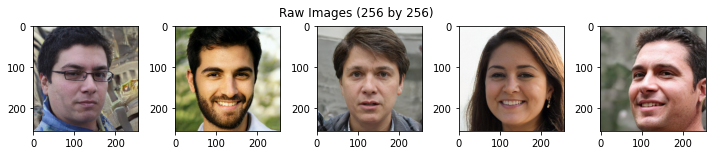

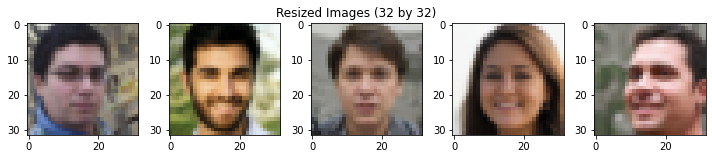

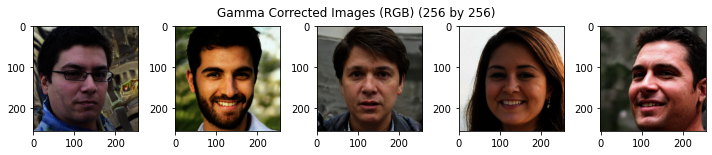

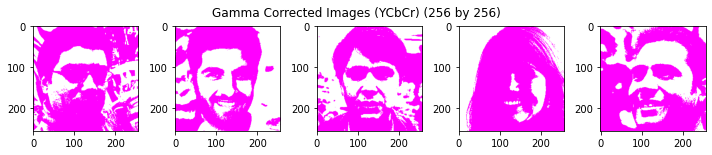

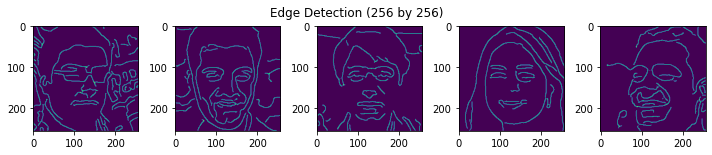

In [ ]:
# Raw images
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  img = plt.imread(svm_sample_images.loc[i,'img_path'])
  plt.imshow(img)
plt.suptitle('Raw Images (256 by 256)',y=0.6)
plt.tight_layout()
plt.show()


# Resized images (32)
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  img = plt.imread(svm_sample_images.loc[i,'img_path'])
  img = resize(img,[32,32,3])
  plt.imshow(img)
plt.suptitle('Resized Images (32 by 32)',y=0.6)
plt.tight_layout()
plt.show()

# Gamma correction on RGB
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  img = plt.imread(svm_sample_images.loc[i,'img_path'])
  img = exposure.adjust_gamma(img,2)
  plt.imshow(img)
plt.suptitle('Gamma Corrected Images (RGB) (256 by 256)',y=0.6)
plt.tight_layout()
plt.show()

# Gamma correction on YCbCr
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  img = plt.imread(svm_sample_images.loc[i,'img_path'])
  img = convert_colorspace(img,'RGB','YCbCr')
  img = exposure.adjust_gamma(img,2)
  img = convert_colorspace(img,'YCbCr','RGB')
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  plt.imshow(img)
  logger.setLevel(old_level)
plt.suptitle('Gamma Corrected Images (YCbCr) (256 by 256)',y=0.6)
plt.tight_layout()
plt.show()

# Edge detection
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  img = plt.imread(svm_sample_images.loc[i,'img_path'])
  img = rgb2gray(img)
  img = feature.canny(img,3)
  plt.imshow(img)
plt.suptitle('Edge Detection (256 by 256)',y=0.6)
plt.tight_layout()
plt.show()

Resizing is straightforward. It scales the images to a specific shape. As we reduce the dimension, the images become fuzzier.

Gamma defines the relationship between a pixel's numerical value and its actual luminance. With a value of 2, this technique makes the images look like they were taken under different lighting conditions. Our interpretation is that certain features are highlighted with gamma correction. 

Applying gamma correction to YCbCr based images, then map the color channels back to RGB changes the look of the images drastically. In some cases, contours of some shapes are preserved while others are abstracted away.

Lastly, edge detection greatly simplifies the images. It focuses only on the boundaries of objects by detecting discontinuities in brightness.

Comparing the different resizing dimensions while keeping other processing techniques constant, we see that the support vector machine algorithm consistently performs the best with the lowest resize dimension among the ones we have experimented. Our initial conjecture is that pixel anomalies that make an image fake can be overwhelmed by regular pixels when the image resolution is high. As a concrete example, suppose the key to detecting a fake face is the pixels around the nose. The rest of the pixels that the image consists of are perfectly normal. Having a 64 by 64 image only serves to dilute the importance of the pixels around the nose, compared with feeding the algorithm a 32 by 32 image. And support vector machine, as an algorithm that seeks to maximize the separation, might be "confused" by the additional redundant information that's not important to classification. 

However, this conjecture is somewhat refuted by the observation that 128 by 128 images leads to a better performance than 64 by 64 images in some settings. This could be a hint of a non-monotone relationship between image resolution and testing performance for support vector machine models. it could be the case that the resizing algorithm abstracts away important information under certain dimensions.

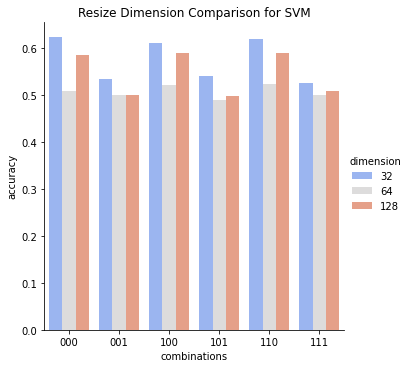

In [ ]:
sns.catplot(x='combinations',y='accuracy',hue='dimension',data=df_svm_melt,palette='coolwarm',kind='bar')
plt.title('Resize Dimension Comparison for SVM')
plt.show()

Focusing on the impact of different preprocessing techniques on performance, we adopt an alternative visualization of the results in the graph below.

Comparing the 000 vs. 001, 100 vs. 101, 110 vs. 111 pairs, it's clear that applying edge detection and transform the data from pixel values for boolean values hurts performance. One the one hand, this could be due to imperfect edge detection. As shown in the visualizations, the chin of the face in the first image isn't properly highlighted. On the other hand, this reinforces the claim that it is primarily pixel value anomalies, not contour/shape anomalies that define a fake image. 

Comparing the 100 vs. 110, 101 vs. 111 pairs, it's not immediately clear how applying gamma correction to YCbCr color channel based images instead of RGB based images affect the model performance.

Comparing the 000 vs. 100, 001 vs. 101 pairs, we cannot draw concrete conclusion regarding how applying gamma correction to RGB images affect performance. Looking at the preprocessing techniques visualizations, we think this lends support to the idea that pixel values anomalies on the contour are key for detection. 

The above observations hold true for 128 by 128 resized images. And the negative impact of edge detection on model performance is not as noticeable with 64 by 64 images. As noted before, model performs poorly with 64 by 64 images in general.

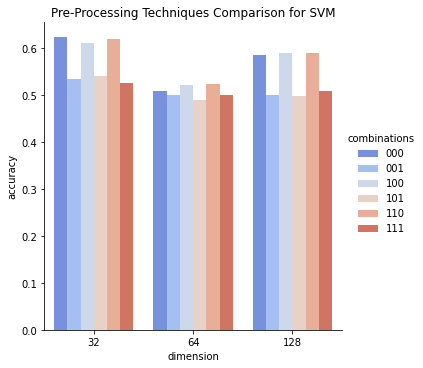

In [ ]:
ax = sns.catplot(x='dimension',y='accuracy',hue='combinations',data=df_svm_melt,palette='coolwarm',kind='bar')
plt.title('Preprocessing Techniques Comparison for SVM')
plt.show()

### Deep Learning Approaches

**Convolution Neural Network**

In [ ]:
process = Utils(random_seed=100)

*CNN Training and Testing*

In [ ]:
for resize_dim in [64,128,256]:
  boolean_args,float_args = process.generate_combos(4,(resize_dim),'cnn')

  for i,bool_vec in enumerate(boolean_args):

    transform = process.cnn_transform(resize_=(bool_vec[0],float_args),
                                      color_jitter_=bool_vec[1],
                                      grayscale_=bool_vec[2],
                                      normalization_=bool_vec[3])
    
    train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
    test_set = datasets.ImageFolder(data_path+'test/',transform=transform)

    batch_size = 256
    train_loader = torch.utils.data.DataLoader(train_set,shuffle=True,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set,shuffle=True,batch_size=batch_size)

    if torch.cuda.is_available():
      print('...Using GPU...')
    else:
      print('...Using CPU...')

    # Hyperparameters
    learning_rate = 0.01
    num_epochs = 15
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Model
    model = CNN(input_dims=(3,resize_dim,resize_dim)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer =  optim.SGD(model.parameters(),lr=learning_rate)
    total_steps = len(train_loader)
    epoch_losses,step_losses = [],[]

    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      for epoch in range(num_epochs):
        step_loss = []
        for j,(images,labels) in enumerate(train_loader):
          imgs = images.to(device)
          labs = labels.to(device)

          outputs = model(imgs)
          loss = criterion(outputs,labs)
          step_loss.append(loss.item())
          step_losses.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (j+1)%100 == 0:
            print('Epoch: {}/{}, Step: {}/{}, Loss: {}.'.format(str(epoch+1).zfill(2),str(num_epochs).zfill(2),j+1,total_steps,loss.item()))
        
        epoch_losses.append(np.mean(step_loss))

    model_name = 'cnn_'+str(resize_dim)+'_'+''.join([str(i) for i in list(map(int,bool_vec))])
    file_path =  os.getcwd()+'/drive/MyDrive/cnn_models/'
    torch.save(model,file_path+model_name+'.pth')

    pickle.dump(epoch_losses,open(file_path+'summary/epoch_losses_'+model_name+'.sav','wb'))
    pickle.dump(step_losses,open(file_path+'summary/step_losses_'+model_name+'.sav','wb'))

    print('Model {}/{} saved.'.format(str(i+1).zfill(2),str(len(boolean_args)).zfill(2)))

    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(2)]
      n_class_samples = [0 for i in range(2)]

      for images,labels in test_loader:
        imgs = images.to(device)
        labs = labels.to(device)
        outputs = model(imgs)
        _,preds = torch.max(outputs,1)
        n_samples += labs.size(0)
        n_correct += (preds==labs).sum().item()

        if len(labs) == batch_size:
          for i in range(batch_size):
            lab = labs[i]
            pred = preds[i]
            if lab == pred:
              n_class_correct[lab] += 1
            n_class_samples[lab] += 1
        
      acc = n_correct/n_samples
      print('Model {} accuracy score on the testing data is {}.'.format(model_name,acc))
      pickle.dump(acc,open(file_path+'summary/accuracy_scores_'+model_name+'.sav','wb'))

In [ ]:
for resize_dim in [256]:
  boolean_args,float_args = process.generate_combos(4,(resize_dim),'cnn')
  boolean_args = [i for i in boolean_args if i!=(True,True,True,True)]

  for i,bool_vec in enumerate(boolean_args):

    transform = process.cnn_transform(resize_=(bool_vec[0],float_args),
                                      color_jitter_=bool_vec[1],
                                      grayscale_ = bool_vec[2],
                                      normalization_=bool_vec[3])
    
    train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
    test_set = datasets.ImageFolder(data_path+'test/',transform=transform)

    batch_size = 256
    train_loader = torch.utils.data.DataLoader(train_set,shuffle=True,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set,shuffle=True,batch_size=batch_size)

    if torch.cuda.is_available():
      print('...Using GPU...')
    else:
      print('...Using CPU...')

    # Hyperparameters
    learning_rate = 0.01
    num_epochs = 15
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Model
    model = CNN(input_dims=(3,resize_dim,resize_dim)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer =  optim.SGD(model.parameters(),lr=learning_rate)
    total_steps = len(train_loader)
    epoch_losses,step_losses = [],[]

    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      for epoch in range(num_epochs):
        step_loss = []
        for j,(images,labels) in enumerate(train_loader):
          imgs = images.to(device)
          labs = labels.to(device)

          outputs = model(imgs)
          loss = criterion(outputs,labs)
          step_loss.append(loss.item())
          step_losses.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (j+1)%100 == 0:
            print('Epoch: {}/{}, Step: {}/{}, Loss: {}.'.format(str(epoch+1).zfill(2),str(num_epochs).zfill(2),j+1,total_steps,loss.item()))
        
        epoch_losses.append(np.mean(step_loss))

    model_name = 'cnn_'+str(resize_dim)+'_'+''.join([str(i) for i in list(map(int,bool_vec))])
    file_path =  os.getcwd()+'/drive/MyDrive/cnn_models/'
    torch.save(model,file_path+model_name+'.pth')

    pickle.dump(epoch_losses,open(file_path+'summary/epoch_losses_'+model_name+'.sav','wb'))
    pickle.dump(step_losses,open(file_path+'summary/step_losses_'+model_name+'.sav','wb'))

    print('Model {}/{} saved.'.format(str(i+1).zfill(2),str(len(boolean_args)).zfill(2)))

    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(2)]
      n_class_samples = [0 for i in range(2)]

      for images,labels in test_loader:
        imgs = images.to(device)
        labs = labels.to(device)
        outputs = model(imgs)
        _,preds = torch.max(outputs,1)
        n_samples += labs.size(0)
        n_correct += (preds==labs).sum().item()

        if len(labs) == batch_size:
          for i in range(batch_size):
            lab = labs[i]
            pred = preds[i]
            if lab == pred:
              n_class_correct[lab] += 1
            n_class_samples[lab] += 1
        
      acc = n_correct/n_samples
      print('Model {} accuracy score on the testing data is {}.'.format(model_name,acc))
      pickle.dump(acc,open(file_path+'summary/accuracy_scores_'+model_name+'.sav','wb'))

*Performance Analysis*

In [ ]:
# Load the testing results - accuracy scores
cnn_models_path = os.getcwd()+'/drive/MyDrive/cnn_models/'

accuracy_scores_cnn = {}

for filename in os.listdir(cnn_models_path+'summary/'):

  item = filename.split('_')[0]
  resize = filename.split('_')[-2]
  bool_vec = filename.split('_')[-1].rstrip('.sav')
  keyword = str(resize)+'_'+str(bool_vec)

  if item=='accuracy':
    file = pickle.load(open(cnn_models_path+'summary/'+filename,'rb'))
    accuracy_scores_cnn[keyword] = file

df_cnn_summary = pd.DataFrame(np.zeros((3,8)),columns=['000','001','010','100','011','101','110','111'],
                                              index=['64','128','256'])

for combo in ['000','001','010','100','011','101','110','111']:
  df_cnn_summary[combo] = np.array([accuracy_scores_cnn[str(size)+'_'+'1'+str(combo)] for size in [64,128,256]])

# Summary table
df_cnn_summary = df_cnn_summary.reset_index()
df_cnn_summary = df_cnn_summary.rename(columns={'index':'dimension'})
df_cnn_summary

,dimension,000,001,010,100,011,101,110,111
0,64,0.74935,0.80695,0.74840,0.73505,0.79875,0.80465,0.73115,0.71405
1,128,0.80075,0.84105,0.80275,0.73525,0.81925,0.81765,0.78385,0.76505
2,256,0.84155,0.88315,0.87250,0.84060,0.89020,0.89485,0.85350,0.81355


In [ ]:
df_cnn_melt = pd.melt(df_cnn_summary,'dimension',var_name='combinations',value_name='accuracy')

For the convolutional nerual network experiements, the binary coding is read as "color jitter on/off, grayscale on/off, normalization on/off". For example, an encoding of 010 represents preprocessing the images without color jitter and normalization, but with grayscale. 

Color jitter randomly change the brightness, contrast, saturation and hue of an image. To an extent, we are trying to randomly simulate different lighting conditions for the images and see if it improves the network's ability to generalize what it learns in the training. 

When grayscale is applied, we choose to preserve three color channels by assigning the same value to them. 

Normalization applies feature scaling to the data set. It improves the consistency of the data by mapping the pixel value distributions to ones with the same mean and standard deviation.

In [ ]:
process = Utils(random_seed=100)

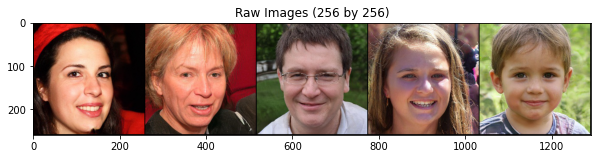

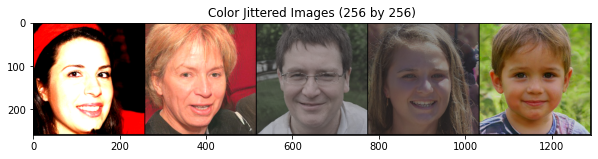

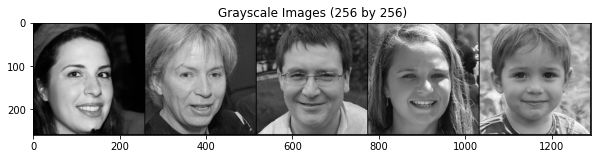

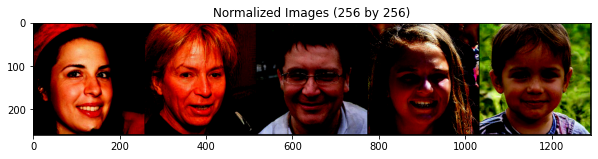

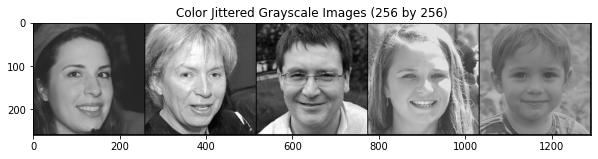

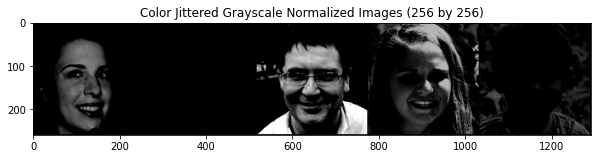

In [ ]:
def imshow(img,title):
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

# Raw images
transform = process.cnn_transform(resize_=(True,256),color_jitter_=False,grayscale_=False,normalization_=False)
train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,shuffle=False,batch_size=5)
data_iter = iter(train_loader)
images,labels = data_iter.next()
imshow(torchvision.utils.make_grid(images),'Raw Images (256 by 256)')

# Color jitter
transform = process.cnn_transform(resize_=(True,256),color_jitter_=True,grayscale_=False,normalization_=False)
train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,shuffle=False,batch_size=5)
data_iter = iter(train_loader)
images,labels = data_iter.next()
imshow(torchvision.utils.make_grid(images),'Color Jittered Images (256 by 256)')

# Grayscale
transform = process.cnn_transform(resize_=(True,256),color_jitter_=False,grayscale_=True,normalization_=False)
train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,shuffle=False,batch_size=5)
data_iter = iter(train_loader)
images,labels = data_iter.next()
imshow(torchvision.utils.make_grid(images),'Grayscale Images (256 by 256)')

# Normalization
transform = process.cnn_transform(resize_=(True,256),color_jitter_=False,grayscale_=False,normalization_=True)
train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,shuffle=False,batch_size=5)
data_iter = iter(train_loader)
images,labels = data_iter.next()
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
imshow(torchvision.utils.make_grid(images),'Normalized Images (256 by 256)')
logger.setLevel(old_level)

# Color jitter and grayscale
transform = process.cnn_transform(resize_=(True,256),color_jitter_=True,grayscale_=True,normalization_=False)
train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,shuffle=False,batch_size=5)
data_iter = iter(train_loader)
images,labels = data_iter.next()
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
imshow(torchvision.utils.make_grid(images),'Color Jittered Grayscale Images (256 by 256)')
logger.setLevel(old_level)

# All three techniques
transform = process.cnn_transform(resize_=(True,256),color_jitter_=True,grayscale_=True,normalization_=True)
train_set = datasets.ImageFolder(data_path+'train/',transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,shuffle=False,batch_size=5)
data_iter = iter(train_loader)
images,labels = data_iter.next()
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
imshow(torchvision.utils.make_grid(images),'Color Jittered Grayscale Normalized Images (256 by 256)')
logger.setLevel(old_level)

Regardless of the preprocessing technique specifications, higher resolution consistently leads to better detection performance for convolutional neural network. This could be another evidence of neural networks being able to pick up and utilize the subtle details in the high resolution images compared to non-deep learning methods. 

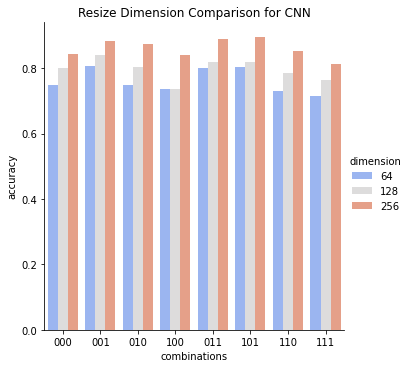

In [ ]:
sns.catplot(x='combinations',y='accuracy',hue='dimension',data=df_cnn_melt,palette='coolwarm',kind='bar')
plt.title('Resize Dimension Comparison for CNN')
plt.show()

Starting with the 000 vs. 001, 010 vs. 011, 100 vs. 101, and 110 vs. 111 pairs, it seems that applying normalization leads to performance gain in all pairs except for the last one. As apparent from the visualizations, applying all three preprocessing techniques make some images unidentifiable. Overall, we still conclude that applying normalization to the images improves the network's ability to generalize the pixel anomalies that define a fake image, and subsequently increases performance. 

Looking at the 000 vs. 010, 001 vs. 011, 100 vs. 110, 101 vs. 111 pairs, we get mixed signals. When only grayscale transformation is applied, we get non-negative performance gains that is increasing with image resolution. Conditional on normalization is applied, applying grayscale leads to performance decrease for lower resolution images. Conditional on applying color jitter, grayscale also increases performance as resolution goes up. Once again, due to the distortion caused by the presence of all three preprocessing techniques, the last pair's comparison doesn't contribute much to the discussion.

Lastly, comparing the 000 vs. 100, 001 vs. 101, 010 vs. 110, 011 vs. 111 pairs, we fail to find an across-the-board consistent observation. Compared with using the null case, applying only the color jitter technique leads to non-positive performance gain. While it could be data set sensitive, perhaps applying random transformation does not help the network to generalize its learning. Conditional on normalization, there's no clear indication how performance is affected. It could be the case that normalization reverts back or weakens some of the changes made by color jittering. Given grayscale images, we see performance decrease for all resolutions. Similar to the observation from applying color jitter to RGB images, our network does not like randomness applied to this data set.

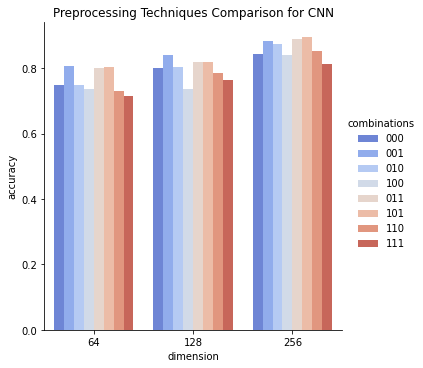

In [ ]:
ax = sns.catplot(x='dimension',y='accuracy',hue='combinations',data=df_cnn_melt,palette='coolwarm',kind='bar')
plt.title('Preprocessing Techniques Comparison for CNN')
plt.show()

In [ ]:
# Load the testing results - step losses
cnn_models_path = os.getcwd()+'/drive/MyDrive/cnn_models/'

step_losses_cnn = {}
epoch_losses_cnn = {}

for filename in os.listdir(cnn_models_path+'summary/'):

  item = filename.split('_')[0]
  resize = filename.split('_')[-2]
  bool_vec = filename.split('_')[-1].rstrip('.sav')
  keyword = str(resize)+'_'+str(bool_vec)[1:]

  if item=='step':
    file = pickle.load(open(cnn_models_path+'summary/'+filename,'rb'))
    step_losses_cnn[keyword] = file
  if item=='epoch':
    file = pickle.load(open(cnn_models_path+'summary/'+filename,'rb'))
    epoch_losses_cnn[keyword] = file

For all combinations of preprocessing techniques, using higher resolution images leads to more rapid reduction of training errors.

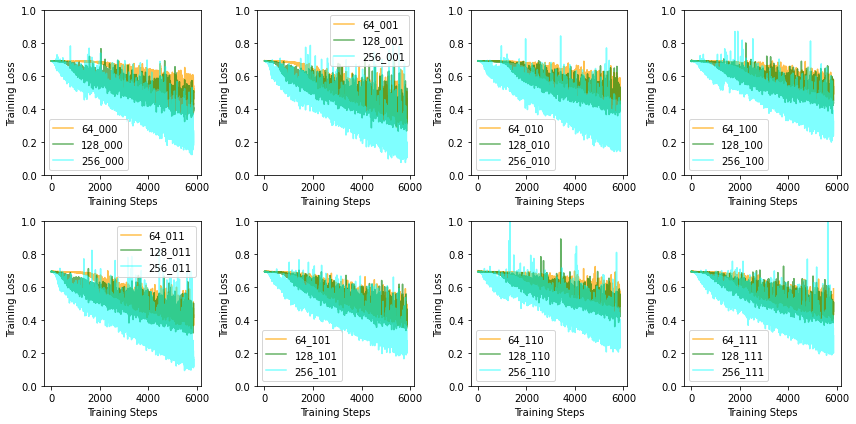

In [ ]:
# Resolution
steps_array = np.array([i+1 for i in range(5865)])

plt.figure(figsize=(12,6))
for i,combo in enumerate(['000','001','010','100','011','101','110','111']):
  plt.subplot(2,4,i+1)
  sns.lineplot(x=steps_array,y=np.array(step_losses_cnn['64_'+combo]),color='orange',label='64_'+combo,alpha=0.7)
  sns.lineplot(x=steps_array,y=np.array(step_losses_cnn['128_'+combo]),color='green',label='128_'+combo,alpha=0.6)
  sns.lineplot(x=steps_array,y=np.array(step_losses_cnn['256_'+combo]),color='cyan',label='256_'+combo,alpha=0.5)
  plt.ylim(0,1)
  plt.ylabel('Training Loss')
  plt.xlabel('Training Steps')

plt.tight_layout()
plt.show()

Among the combinations of preprocessing techniques tested, applying nothing but normalization yields the fastest training loss reduction over the epochs. Applying color jitter leads to the slowest training loss reduction. This could be due to the randomness added by color jittering, as noted in previous discussion.

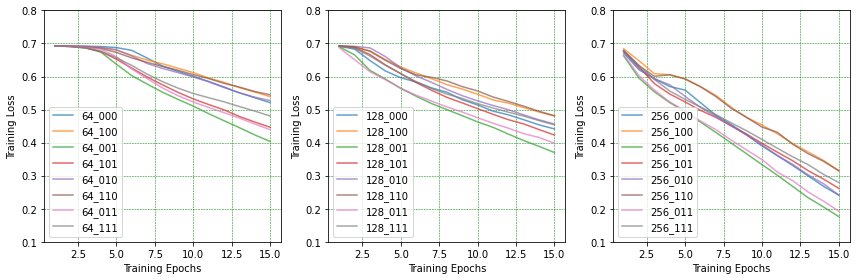

In [ ]:
# Preprocessing techniques
epochs_array = np.array([i+1 for i in range(15)])

plt.figure(figsize=(12,4))
for i,dim in enumerate([64,128,256]):
  plt.subplot(1,3,i+1)
  for combo in ['000','100','001','101','010','110','011','111']:
    sns.lineplot(x=epochs_array,y=np.array(epoch_losses_cnn[str(dim)+'_'+combo]),label=str(dim)+'_'+combo,alpha=0.7,linestyle='-')
  plt.ylim(0.1,0.8)
  plt.ylabel('Training Loss')
  plt.xlabel('Training Epochs')
  plt.grid(color='green',linestyle='--',linewidth=0.5)

plt.tight_layout()
plt.show()